In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pickle

## Config

In [2]:
SEARCH_BS = False
# SEARCH_BS = True
SEARCH_LR = False
# SEARCH_LR = True

In [3]:
from __future__ import division


DEBUG = False
# DEBUG = True
SUBCONJUNT = False
# SUBCONJUNT = True
TRAIN_ONE_IMAGE = False
# TRAIN_ONE_IMAGE = True

# Resize images
resize_img = 1300
if DEBUG:
    resize_img = 100
if TRAIN_ONE_IMAGE:
    resize_img = 100
if SUBCONJUNT:
    resize_img = 700
resize_img = 32*(resize_img//32)

# Subconjunt division factor
if SUBCONJUNT:
    division_factor = 10

# Batch size
BS_train = 4
if SEARCH_LR:
    BS_train = int(BS_train / 4)
    if BS_train == 0:
        BS_train = 1
if DEBUG:
    BS_train = 32
if SUBCONJUNT:
    BS_train = 8
BS_val = BS_train * 4

# Train
EPOCHS = 400
if DEBUG:
    EPOCHS = 3
if TRAIN_ONE_IMAGE:
    EPOCHS = 100
if SUBCONJUNT:
    EPOCHS = 100

# Learning rate
LR = 1e-2

# Save best model
NOTEBOOK_NAME = '10_Resnet50_one_class_subconjunt'

# Dataset split
VALID_SPLIT = 0.2

# Model
number_of_classes = 1
number_of_channels = 3
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
activation = None
name_best_model = f'{NOTEBOOK_NAME}_best_model.pth'
name_early_stopping_model = f'{NOTEBOOK_NAME}_early_stopping.pth'
name_final_model = f'{NOTEBOOK_NAME}_final_model.pth'
path_to_save_models = path = Path("../models/")
path_best_model = path_to_save_models / name_best_model
path_early_stopping_model = path_to_save_models / name_early_stopping_model
path_final_model = path_to_save_models / name_final_model

# Learning rate decay
LE_DECAY_FACTOR = 0.1
LE_DECAY_PATIENCE = 10

# Early stopping
EARLY_STOPPING = False
EARLY_STOPPING_PATIENCE = 30

# Epochs when model can be saved
MIN_SAVE_EPOCHS = 10

## Dataframe

In [4]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [5]:
train_images_path = data_path / "train_images"

In [6]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## Dice coefficient loss

In [7]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    # mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_cv_res).float().unsqueeze(0)#.permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [10]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(train_split)} imágenes de entrenamiento y {len(val_split)} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [11]:
if not TRAIN_ONE_IMAGE:
    if not SUBCONJUNT:
        dataset = {
            'train': Dataset(train_split, n_classes=2, dim=resize_img),
            'val': Dataset(val_split, n_classes=2, dim=resize_img),
        }
    else:
        dim_train = len(train_split)//division_factor
        dim_val = len(val_split)//division_factor
        dataset = {
            'train': Dataset(train_split[0:dim_train], n_classes=2, dim=resize_img),
            'val': Dataset(val_split[0:dim_val], n_classes=2, dim=resize_img),
        }
else:
    idx_t = np.random.randint(0, len(train_split))
    idx_v = np.random.randint(0, len(val_split))
    dataset = {
        'train': Dataset(train_split.iloc[idx_t:idx_t+1], n_classes=2, dim=resize_img),
        'val': Dataset(val_split.iloc[idx_v:idx_v+1], n_classes=2, dim=resize_img),
    }

In [12]:
if not TRAIN_ONE_IMAGE:
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
    }
else:
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
        'val': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_val, pin_memory=True)
    }

## Model initialization

In [13]:
def model_init():
    model = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=number_of_channels, classes=number_of_classes, activation=activation)
    return model

## Batch size finder

In [14]:
if SEARCH_BS:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [15]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [16]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [17]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    print(BSs)

In [18]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                if "CUDA out of memory" in str(e):
                    position = str(e).index('CUDA out of memory')
                    print(f"\t{str(e)[position:]}")
                    out_of_memory = True
                    break
                else:
                    out_of_memory = False
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [19]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [20]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [21]:
if SEARCH_LR:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [22]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [23]:
# from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device, epoch, epochs):
    train_loss, train_dice = [], []
    model.train()
    # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
    for imgs, masks in bar:
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update train loss and dice
        pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\tEpoch {epoch}/{epochs}: loss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device, epoch, epochs):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tEpoch {epoch}/{epochs}: val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    early_stop_counter = 0
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=LE_DECAY_FACTOR, patience=LE_DECAY_PATIENCE, verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    checkpoints = {'best model epoch': 0, 'best model dice': 0, 'early stopping epoch': 0, 'early stopping dice': 0, 'final model epoch': 0, 'final model dice': 0}
    for epoch in range(epochs):
        # Train
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device, epoch, epochs)

        # Validation
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device, epoch, epochs)
        
        # Save model if best dice
        if hist['val_dice'][-1] > best_dice and epoch >= MIN_SAVE_EPOCHS:
            best_dice = hist['val_dice'][-1]
            torch.save(model, path_best_model)
            print(f"New best dice: {best_dice:.5f}, model saved to {path_best_model}")
            checkpoints['best model epoch'] = epoch
            checkpoints['best model dice'] = best_dice
        
        # Update scheduler
        schedulerOnPlateau.step(hist['val_loss'][-1])

        # Early stopping
        if hist['val_dice'][-1] < best_dice:
            early_stop_counter += 1
            if early_stop_counter == EARLY_STOPPING_PATIENCE+1:
                torch.save(model, path_early_stopping_model)
                print(f"Early stopping at epoch {epoch+1}")
                print(f"Early stopping dice: {hist['val_dice'][-1]}, model saved to {path_early_stopping_model}")
                checkpoints['early stopping epoch'] = epoch
                checkpoints['early stopping dice'] = hist['val_dice'][-1]
                if EARLY_STOPPING:
                    break
        else:
            early_stop_counter = 0
        
    # Save final model
    torch.save(model, path_final_model)
    print(f"Final model dice: {hist['val_dice'][-1]}, saved to {path_final_model}")
    checkpoints['final model epoch'] = epoch
    checkpoints['final model dice'] = hist['val_dice'][-1]
    
    return hist, checkpoints

In [24]:
if not SEARCH_BS and not SEARCH_LR:
    model = model_init()
    hist, checkpoints = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


	Epoch 0/100: loss 0.71626, dice 0.17094: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]
		Epoch 0/100: val_loss 2782526506532864.00000 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
	Epoch 1/100: loss 0.32724, dice 0.00001: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
		Epoch 1/100: val_loss 391528284160.00000 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
	Epoch 2/100: loss 0.27426, dice 0.00001: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
		Epoch 2/100: val_loss 17928462336.00000 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
	Epoch 3/100: loss 0.30480, dice 0.00000: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
		Epoch 3/100: val_loss 59818632.00000 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
	Epoch 4/100: loss 0.27866, dice 0.00000: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
		Epoch 4/100: val_loss 700205.68750 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
	Epoch 5/100: loss 0.27269, dice

New best dice: 0.00000, model saved to ../models/10_Resnet50_one_class_subconjunt_best_model.pth


		Epoch 11/100: val_loss 3.88143 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.


		Epoch 22/100: val_loss 0.45705 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


		Epoch 33/100: val_loss 0.41357 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.


		Epoch 44/100: val_loss 0.43546 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.


		Epoch 55/100: val_loss 0.41922 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Epoch 00056: reducing learning rate of group 0 to 1.0000e-07.


		Epoch 66/100: val_loss 0.44014 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Epoch 00067: reducing learning rate of group 0 to 1.0000e-08.


		Epoch 99/100: val_loss 0.41633 val_dice 0.00000: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Final model dice: 1.765243723639287e-06, saved to ../models/10_Resnet50_one_class_subconjunt_final_model.pth


In [25]:
print(f"Best model epoch: {checkpoints['best model epoch']}, dice: {checkpoints['best model dice']}")
print(f"Early stopping epoch: {checkpoints['early stopping epoch']}, dice: {checkpoints['early stopping dice']}")
print(f"Final model epoch: {checkpoints['final model epoch']}, dice: {checkpoints['final model dice']}")

Best model epoch: 10, dice: 1.765243723639287e-06
Early stopping epoch: 0, dice: 0
Final model epoch: 99, dice: 1.765243723639287e-06


## Check fit

In [26]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

100


,loss,dice,val_loss,val_dice
0,0.716260,0.170937,2.782527e+15,0.000002
1,0.327242,0.000013,3.915283e+11,0.000002
2,0.274265,0.000006,1.792846e+10,0.000002
3,0.304801,0.000004,5.981863e+07,0.000002
4,0.278660,0.000005,7.002057e+05,0.000002


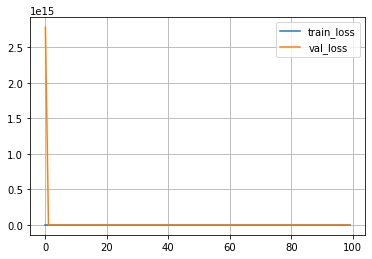

In [27]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

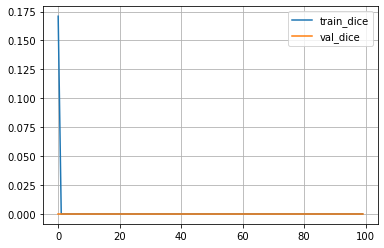

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    idx = np.random.randint(0, len(sample_val_img))
    one_sample_img = sample_val_img[idx]
    one_sample_mask = sample_val_mask[idx]

In [30]:
if not SEARCH_BS and not SEARCH_LR:
    def check_model(model, img, mask, type=''):
        model.eval()
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            pred_mask = model(img).squeeze()
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = pred_mask > 0.5
            pred_mask = pred_mask.detach().cpu().numpy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
        ax1.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        ax1.set_title('Image')
        ax2.imshow(mask.cpu().numpy().squeeze(0))
        ax2.set_title('mask')
        ax3.imshow(pred_mask)
        ax3.set_title(f'pred_mask {type}')
        plt.show()

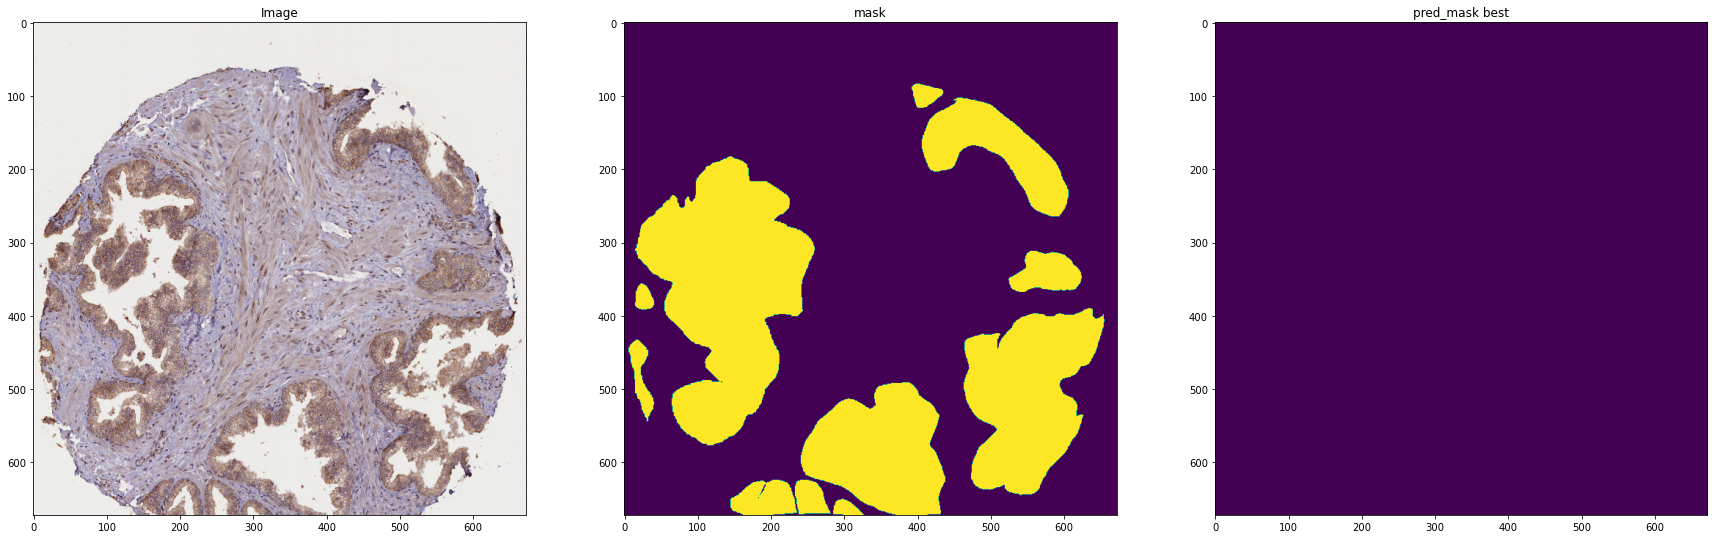

In [31]:
# Best model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_best_model)
    check_model(model, one_sample_img, one_sample_mask, type='best')

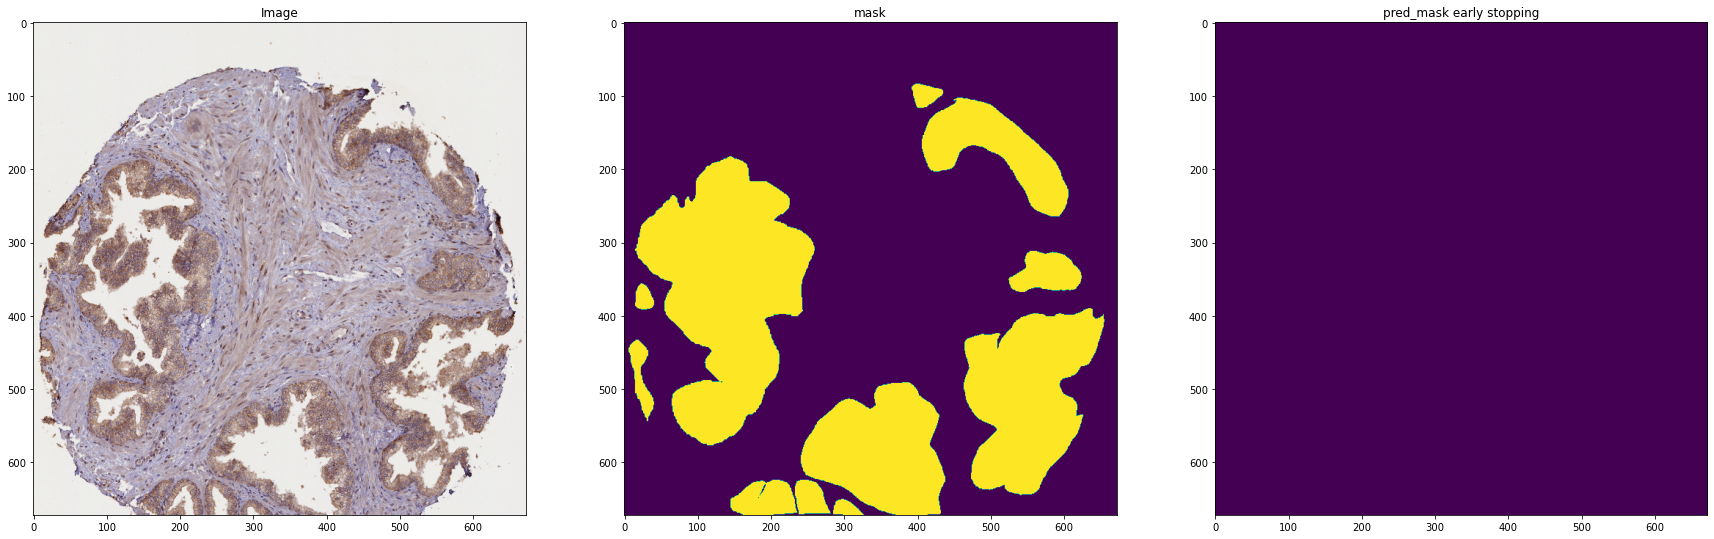

In [32]:
# Early stopping model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_early_stopping_model)
    check_model(model, one_sample_img, one_sample_mask, type='early stopping')

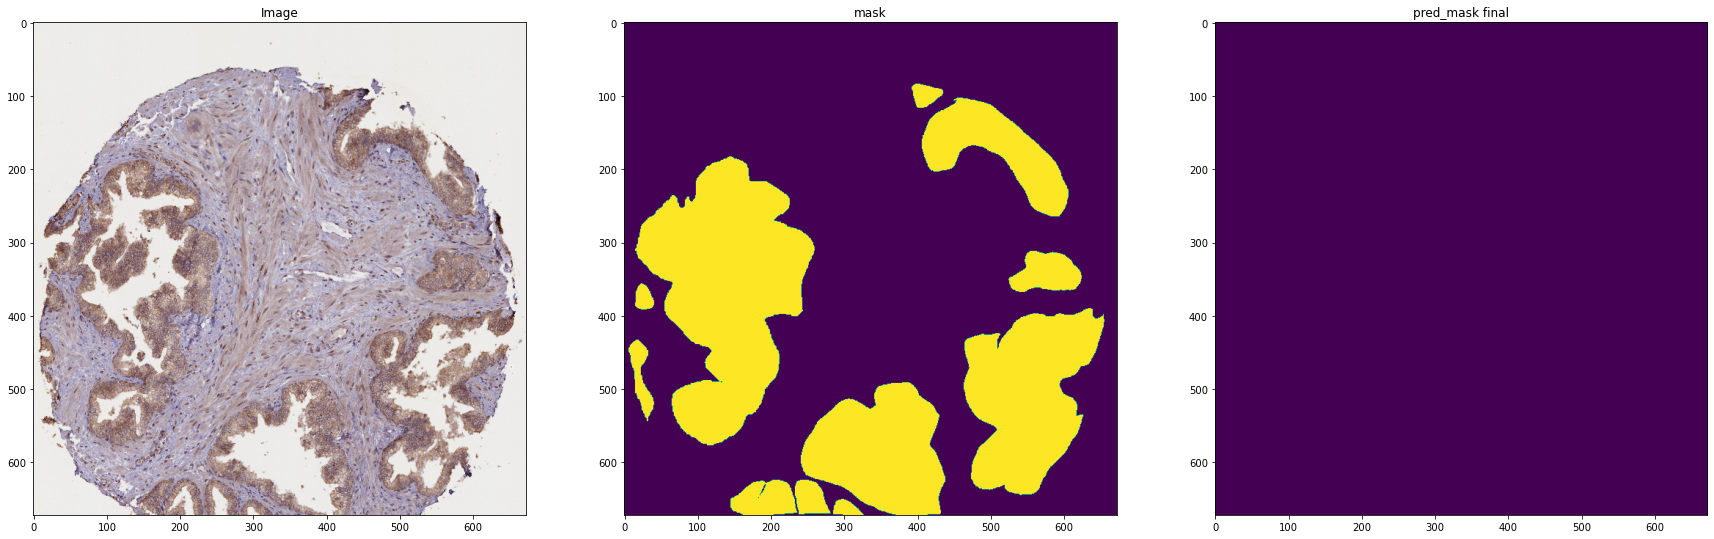

In [33]:
# Final model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_final_model)
    check_model(model, one_sample_img, one_sample_mask, type='final')